In [1]:
import jax
print("jax version: ", jax.__version__)
import jax.numpy as np
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

rng = jax.random.PRNGKey(2)

jax version:  0.2.10


In [2]:
# for model stuff
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
from jax import jit

# for imnn
import imnn
import imnn.lfi
import jax
import jax.numpy as np
import jax_cosmo as jc
import matplotlib.pyplot as plt
import tensorflow_probability
from jax.experimental import optimizers
from jax.experimental import stax
tfp = tensorflow_probability.substrates.jax
rng = jax.random.PRNGKey(0)

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
N=20

In [5]:
def scipy_compute_r2(N):
    _Di = np.tile(toeplitz(np.arange(N)), (N, N))
    _Dj = np.concatenate(
        [np.concatenate(
            [np.tile(np.abs(i - j),(N, N)) 
             for i in range(N)], 
            axis=0)
         for j in range(N)],
        axis=1)
    _distance_squared = _Di * _Di + _Dj * _Dj
    return _distance_squared

def compute_r2(N):
    _r2 = np.tile(np.abs(np.expand_dims(np.arange(N), 0) 
                    - np.expand_dims(np.arange(N), 1)), (N, N)) ** 2. + np.abs(np.expand_dims(np.repeat(np.arange(N), N), 0) 
                             - np.expand_dims(np.repeat(np.arange(N), N), 1)) ** 2.
    return _r2

r2 = compute_r2(N).astype(np.float32)

def ξ_G(β):
    return np.exp(
        -np.expand_dims(r2, tuple(np.arange(β.ndim))) 
        / 4. / np.expand_dims(β, (-2, -1))**2.)

def get_G_field(β):
    pass

def fill_zeros(k, value):
    from functools import partial

    def fnk(k):
        return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: value, lambda k: k+value, operand=k)

    if len(k.shape) == 1:
        return jax.vmap(fnk)(k)
    else:
        return jax.vmap(partial(fill_zeros, value=value))(k)


def xi_LN(r, α, β, PixelNoise=0.01):

    xi = 1/(np.power(α+1e-12,2)) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)

    # Add pixel noise at zero separation:

    xi = fill_zeros(xi, PixelNoise**2)
    #xi[np.where(r<1e-5)] += PixelNoise**2

    return xi

In [6]:
def dxi_LN_dalpha(r, α, β):

    _deriv =  2/(α+1e-12) * np.exp(-0.25*np.power(r/β,2)) * np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 2/np.power(α+1e-12,3) * (np.exp(np.power(α,2)*np.exp(-0.25*np.power(r/β,2))) - 1)
    return _deriv

def dxi_LN_dbeta(r, β, α):

    return (0.5*np.power(r, 2) * np.exp(np.power(α, 2) * np.exp(-0.25 * np.power(r/β,2)) - 0.25*np.power(r/β,2)))*np.power(1./β,3)

In [85]:
θ_fid = np.array([1.0, 0.5], dtype='float32')

r = np.sqrt(r2)
Nsq=N**2

In [98]:
def dξdβ(β):
    return 0.5 * ((1./β)**3) * r2 * np.exp(-0.25 * r2 * (1./β)**2)
def known_fisher(θ, Nsq):
    α,β = θ
    # get covariance
    _ξ    = ξ_G(β)
    # get derivative
    dξ_dβ   = dξdβ(β) 
    
    Cinv = np.linalg.inv(_ξ)        
    
    # fisher matrix entries
    Faa = 2*Nsq / α**2
    Fab = (1. / α) * np.trace(Cinv @ dξ_dβ)
    Fba = Fab
    Fbb = 0.5 * np.trace(Cinv @ dξ_dβ @ Cinv @ dξ_dβ)

    return np.array([[Faa, Fab], [Fba, Fbb]])

In [99]:
f = -known_fisher(θ_fid, Nsq)
print(f)

analytic_detF = np.linalg.det(f)
print(analytic_detF)

[[ -800.      1215.2695]
 [ 1215.2695 -5815.559 ]]
3175567.2


In [100]:
F_expected

DeviceArray([[1131.4912, 2208.2646],
             [2208.2646, 4518.899 ]], dtype=float32)

In [101]:
detF_expected

DeviceArray(236661.44, dtype=float32)

In [103]:
analytic_detF / detF_expected

DeviceArray(13.418186, dtype=float32)

In [140]:
def _f_NL(α, β):
    return tfd.TransformedDistribution(
      distribution=tfd.MultivariateNormalTriL(
          loc=np.zeros((N**2,)),
          scale_tril=np.linalg.cholesky(ξ_G(β))),
      bijector= tfb.Chain([
          tfb.Exp(),
          tfb.AffineScalar(
              #shift=-0.5 * np.expand_dims(α, -1)**2.,
              scale=np.expand_dims(α, -1))]))

def loglike(α, β, key):
    f_NL = _f_NL(α, β)
    return f_NL.log_prob(f_NL.sample(seed=key))

@jax.jit
def dlnLdθ(α, β, key):
    return jax.grad(loglike, argnums=(0, 1))(α, β, key)

def numeric_F(α, β, key, n_samples):
    keys = np.array(jax.random.split(key, num=n_samples))
    return np.cov(np.array(jax.vmap(dlnLdθ)(np.repeat(α, n_samples), np.repeat(β, n_samples), keys)), rowvar=True)


In [133]:
def hessian_F(α, β, key, n_samples):
    keys = jax.random.split(key, num=n_samples)

    # Compile a function that computes the Hessian of the likelihood
    hessian_loglik = jax.jit(jax.hessian(loglike, argnums=(0,1)))

    # Evalauate the Hessian at fiductial cosmology to retrieve Fisher matrix
    
    return np.mean(np.array([hessian_loglik(α, β, k) for k in keys]), axis=0)

In [134]:
num_f = hessian_F(_a, _b, key, 1000)

In [135]:
num_f

DeviceArray([[ 4.0000003e+02, -1.8772304e+00],
             [-1.8772302e+00,  3.1353657e+03]], dtype=float32)

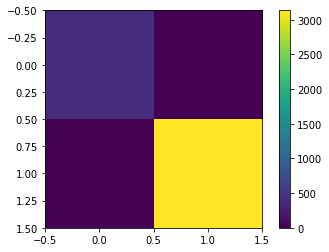

In [137]:
plt.imshow(num_f)
plt.colorbar()

In [138]:
det_num_f = np.linalg.det(num_f)
det_num_f

DeviceArray(1254142.5, dtype=float32)

In [141]:
rng, key = jax.random.split(rng)
_a,_b = θ_fid
#F_expected = #np.mean(np.array([numeric_F(np.array(_a), np.array(_b), key, 20)
              #                  for i in range(10)
               #                   ]), axis=0)

F_expected = numeric_F(np.array(_a), np.array(_b), key, 500)
detF_expected = np.linalg.det(F_expected)

print('expected F: ', F_expected)
print('expected det F: ', (detF_expected))

expected F:  [[1235.5773 2387.6042]
 [2387.6042 4819.7935]]
expected det F:  254573.47


In [144]:
print('difference from analytic F: ', np.abs(analytic_detF) / det_num_f)

difference from analytic F:  2.5320625


In [145]:
print('difference from analytic F: ', np.abs(analytic_detF) / detF_expected)

difference from analytic F:  12.47407


# define LN class

In [415]:
# Define a log_normal field class (Florent's paper -> JAX)
class LogNormalField:
    @staticmethod
    def compute_rsquared(nside):
        """
        Compute the correlation function of the underlying gaussian field
        
        Parameters:
            nside : int
                Image is nside x nside pixels
        """
        import jax.numpy as np
        from scipy.linalg import toeplitz
        
        _Di = np.tile(toeplitz(np.arange(nside)),(nside,nside))
        _Dj = np.concatenate(
                            [np.concatenate(
                                            [np.tile(np.abs(i-j),(nside,nside)) for i in range(nside)],
                                            axis=0)
                            for j in range(nside)],axis=1)
        _distance_squared = _Di*_Di+_Dj*_Dj
        
        return _distance_squared

    # The lognormal correlation function where the gaussian field has a gaussian power spectrum,
    # and the gaussian correlation function xi_G.

    @staticmethod
    def xi_G(rsq, beta):
        """
        Calculates the two-point correlation function of a gaussian field with gaussian power spectrum
        
        Parameters:
        
        rsq : float
            separation^2
        beta  : float
            Gaussian smoothing width of gaussian field
        """
        import jax.numpy as np
        
        # ADD IN SIGMA PARAM HERE
        
        xi = np.exp(-0.25*rsq/(beta**2))
            
        return xi
    
    @staticmethod
    def fill_zeros(k, value):
        from functools import partial
        
        def fnk(k):
            return jax.lax.cond(np.less_equal(k, 1e-5), lambda _: 0., lambda k: k+value, operand=k)

        if len(k.shape) == 1:
            return jax.vmap(fnk)(k)
        else:
            return jax.vmap(partial(fill_zeros, value=value))(k)

    @staticmethod
    def xi_LN(r, beta, alpha, PixelNoise):
        """
        Calculates the lognormal two-point correlation function
        
        Parameters:
        
        r : float
            Pair separation
        beta  : float
            Gaussian smoothing width of underlying gaussian field
        alpha : float
            Nongaussianity parameter in lognormal transformation
        PixelNoise : float
            Standard deviation of added noise per pixel
        """
        import jax.numpy as np
        
        xi = 1/(np.power(alpha+1e-12,2)) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
        
        # Add pixel noise at zero separation:
                
        xi = self.fill_zeros(xi, PixelNoise**2)
        #xi[np.where(r<1e-5)] += PixelNoise**2
        
        return xi
    
    @staticmethod
    def dxi_LN_dalpha(r, beta, alpha, PixelNoise):
        import jax.numpy as np
        
        return 2/(alpha+1e-12) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 2/np.power(alpha+1e-12,3) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
    
    @staticmethod
    def dxi_LN_dbeta(r, beta, alpha, PixelNoise):
        import jax.numpy as np
        
        return (0.5*np.power(r,2)/np.power(beta,3)) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2)))


    def __init__(self,Lside,rmax,nbin):
        """
        
        Parameters:
            rmax : float
                Maximum pair separation considered
            nbin : int
                Number of bins for shell-averaged correlation function
        """
        import jax.numpy as np
        
        self.rmax       = rmax
        self.nbin       = nbin
        self.Lside      = Lside

        # compute the separations and indices on a grid
        self.rsq        = self.compute_rsquared(Lside)
        self.r          = np.sqrt(self.rsq)
        self.bins       = np.arange(nbin)*rmax/nbin
        self.index      = np.digitize(self.r,self.bins)
        self.average_r  = np.array([self.r[self.index == n].mean() for n in range(nbin) if np.sum(self.index == n)>0])
    
    @staticmethod
    def G_to_LN(gaussian, alpha):
        import jax.numpy as np
        
        # Make lognormal (variance of gaussian field is unity by construction)
        # Divide by 1/alpha so that the signal-to-noise ratio is independent of alpha
        return np.exp(alpha * gaussian) #1./alpha * (np.exp(alpha * gaussian-0.5*alpha**2)-1)
    
    def run_simulation(self, key, alpha, beta, PixelNoise=None):
        """
        Create a lognormal field from a gaussian field with a Gaussian correlation function
        """
        
        # split keys, one for field and one for noise
        key1,key2 = jax.random.split(key)
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        # Compute the Gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        
        # Compute the Gaussian random field
        field = (jax.random.multivariate_normal(key1, np.zeros(Lside*Lside), xiG)).reshape(Lside,Lside) 
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(field, alpha)
        
        # Add noise
        if PixelNoise is not None:
            field += jax.random.normal(key2, shape=(Lside,Lside))*np.sqrt(PixelNoise)
        
        return field
    
    def pymc3_model(self, field_data, alphamin, alphamax, betamin, betamax, PixelNoise):
        import numpy as np
        import pymc3 as pm
        LN_model = pm.Model()
        
        Lside              = self.Lside
        rsq                = self.rsq
        zero               = np.zeros(Lside*Lside)
        PixelNoiseVector   = PixelNoise*np.ones(Lside*Lside)
        InvNoiseCovariance = np.diag(1/(PixelNoiseVector**2))
        field_data         = field_data.reshape(Lside*Lside)

        with LN_model:
            
            # (TLM) TODO: add in μ,σ for full BHM

            # Uniform priors for unknown model parameters (alpha,beta):

            alpha_p   = pm.Uniform("alpha", lower=alphamin, upper=alphamax)
            beta_p    = pm.Uniform("beta",  lower=betamin,  upper=betamax)

            # Compute (beta-dependent) gaussian field correlation function:

            xi = pm.math.exp(-0.25*rsq/(beta_p*beta_p))

            # Gaussian field values are latent variables:
            gaussian = pm.MvNormal("gaussian",mu=zero,cov=xi,shape=Lside*Lside)

            # Expected value of lognormal field, for given (alpha, beta, gaussian):

            muLN = 1/alpha_p * (pm.math.exp(alpha_p * gaussian-0.5*alpha_p*alpha_p)-1)

            # Likelihood (sampling distribution) of observations, given the mean lognormal field:

            Y_obs = pm.MvNormal("Y_obs", mu=muLN, tau=InvNoiseCovariance, observed=field_data)
        
        return LN_model
    
    def run_diff_simulation(self, alpha, beta, PixelNoise, step, seed):
        """
        Run simulations for finite differencing
        """
        import numpy as np
        from scipy.stats import multivariate_normal
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        alphap     = alpha*(1+step)
        alpham     = alpha*(1-step)
        betap      = beta*(1+step)
        betam      = beta*(1-step)
        
        # Compute the gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        xiG_betap = self.xi_G(rsq,betap)
        xiG_betam = self.xi_G(rsq,betam)
        
        # Compute Gaussian random fields with the same phases
        Gfield = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betap = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betap).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betam = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betam).rvs(random_state=seed).reshape(Lside,Lside)
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(Gfield, alpha)
        field_betap = self.G_to_LN(Gfield_betap, alpha)
        field_betam = self.G_to_LN(Gfield_betam, alpha)
        field_alphap = self.G_to_LN(Gfield, alphap)
        field_alpham = self.G_to_LN(Gfield, alpham)
        
        # Add noise
        noise = np.random.normal(loc=0.0,scale=PixelNoise,size=(Lside,Lside))
        field += noise
        field_betap += noise
        field_betam += noise
        field_alphap += noise
        field_alpham += noise
        
        return field, field_alphap, field_alpham, field_betap, field_betam
    
    def compute_corrfn(self,field):
        """
        Compute two-point correlation function
        """       
        import numpy as np
        
        index    = self.index
        nbin     = self.nbin
        
        # compute the correlations
        correlations = np.outer(field,field)
        corrfn = np.array([correlations[index==n].mean() for n in range(nbin) if len(correlations[index==n])>0])
        
        return corrfn
    
    def compute_corrfn_derivatives(self, field, field_alphap, field_alpham, field_betap, field_betam, step):
        """
        Compute derivatives of the two-point correlation function
        """
        
        # Compute correlation functions
        corrfn         = self.compute_corrfn(field)
        corrfn_dalphap = self.compute_corrfn(field_alphap)
        corrfn_dalpham = self.compute_corrfn(field_alpham)
        corrfn_dbetap  = self.compute_corrfn(field_betap)
        corrfn_dbetam  = self.compute_corrfn(field_betam)
        
        # Compute derivatives by second-order central finite differences
        dcorrfn_dalpha = (corrfn_dalpham - 2*corrfn + corrfn_dalphap)/(step**2)
        dcorrfn_dbeta  = (corrfn_dbetam  - 2*corrfn + corrfn_dbetap )/(step**2)
        
        return dcorrfn_dalpha, dcorrfn_dbeta
    
    def covariance(self,fields):
        """
        Compute covariance from a number of fields
        
        Parameter:
            fields : int
                lognormal field objects contributing to the covariance matrix
        """
        import numpy as np
        
        nsims  = len(fields)
        nbins  = self.nonzerobins
        
        print('Number of simulations',nsims)
        print('Number of non-zero pair bins',nbins)
        
        corrfns = np.array([fields[i]['corrfn'] for i in range(nsims)])
        meanxi = np.mean(corrfns,axis=0)
        covxi = np.cov(corrfns.T)
        
        return meanxi, covxi
    
    # Utility properties
    @staticmethod
    def var_th(alpha, PixelNoise):
        import numpy as np
        return 1/np.power(alpha+1e-12,2)*(np.exp(alpha**2)-1)+PixelNoise**2
    @staticmethod
    def skew_th(alpha):
        import numpy as np
        return (np.exp(alpha**2)+2)*np.sqrt(np.exp(alpha**2)-1)
    @staticmethod
    def dskew_dalpha(alpha):
        import numpy as np
        return 2*alpha*np.exp(alpha**2) * ( np.sqrt(np.exp(alpha**2)-1) - 0.5*(np.exp(alpha**2)+2)/(np.sqrt(np.exp(alpha**2)-1)) )
    @staticmethod
    def kurtosis_th(alpha):
        import numpy as np
        return np.exp(4*alpha**2)+2*np.exp(3*alpha**2)+3*np.exp(2*alpha**2)-6
    @staticmethod
    def dkurtosis_dalpha(alpha):
        import numpy as np
        return 8*alpha*np.exp(4*alpha**2)+6*alpha*np.exp(3*alpha**2)+6*alpha*np.exp(2*alpha**2)
    @staticmethod
    def max(field):
        import numpy as np
        return np.max(field)
    @staticmethod
    def min(field):
        import numpy as np
        return np.min(field)
    @staticmethod
    def var(field):
        import numpy as np
        return np.var(field)
    @staticmethod
    def mean(field):
        import numpy as np
        return np.mean(field)
    @staticmethod
    def skew(field):
        from scipy.stats import skew
        return skew(field.flatten())
    @staticmethod
    def kurtosis(field):
        from scipy.stats import kurtosis
        return kurtosis(field.flatten())
    
    # xi has empty bins removed.  Note the number of non-empty elements
    @property
    def nonzerobins(self):
        return len(self.average_r)
    
    @property
    def dt(self):
        import numpy as np
        return np.dtype([('field', np.float, (self.Lside,self.Lside)), ('corrfn', np.float, (self.nonzerobins))])
# end class LogNormalField


# define simulator

In [416]:
Lside       = N
alpha       = 1.0
beta        = 0.5
PixelNoise  = 0.01


# Setup for correlation function
nbin        = 4*Lside
ndata       = 4*Lside
rmax        = Lside*np.sqrt(2)

LN=LogNormalField(Lside,rmax,nbin)
field = LN.run_simulation(key, 1.0, 0.5, PixelNoise=None)

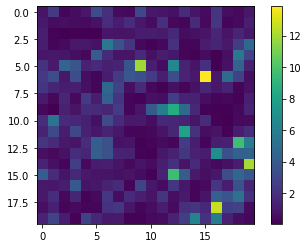

In [417]:
plt.imshow(np.squeeze(field))
plt.colorbar()

In [418]:
# simulator args
simulator_args = {'N': N, 'squeeze': False, 'pad': 2}

In [419]:
# LN field distribution
def _f_NL(α, β):
    return tfd.TransformedDistribution(
        distribution=tfd.MultivariateNormalTriL(
            loc=np.zeros((N**2,)),
            scale_tril=np.linalg.cholesky(ξ_G(β))),
        bijector=tfb.Chain([
            tfb.Scale(1. / np.expand_dims(α, (-1))), 
            tfb.Expm1(),
            tfb.AffineScalar(
                shift=-0.5 * np.expand_dims(α, -1)**2.,
                scale=np.expand_dims(α, -1))]))


# draw from the joint distribution
def simulator(rng, n, α, β,):
    dist = _f_NL(α, β)
    if n is not None:
        return dist.sample(n, seed=rng)
    else: 
        return dist.sample(seed=rng)


# simulator uses Florent's LN field simulator
# wrapper for IMNN and ABC sampler
def imnn_simulator(rng, θ, simulator_args=simulator_args):
    A,B = θ
    N = simulator_args['N']
    pad = simulator_args['pad']
    #noise = 0.01
    def fn(key, A, B):
        if simulator_args['squeeze']:
            return np.expand_dims(
                np.pad(
                    #simulator(key, None, A, B).reshape(N,N), 
                    LN.run_simulation(key, A, B),
                    [pad,pad],
                    ), 
                0)

        else:
            return (np.expand_dims(
                        np.expand_dims(
                            np.pad(
                                #simulator(key, None, A, B).reshape(N,N),
                                LN.run_simulation(key, A, B),
                                [pad,pad]
                                ),  
                            0), 
                0))

    if A.shape == B.shape:
        if len(A.shape) == 0:
            return fn(rng, A, B)
        else:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A, B: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, A, B)
    else:
        if len(A.shape) > 0:
            keys = jax.random.split(rng, num=A.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, A: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, A)
        elif len(B.shape) > 0:
            keys = jax.random.split(rng, num=B.shape[0])
            return jax.vmap(
                lambda key, B: imnn_simulator(key, (A,B), simulator_args=simulator_args)
            )(keys, B)
    

In [420]:
pad = 2 #2**2
input_shape = (1,1, N+pad*2,N+pad*2)
print('input shape: ', input_shape)
θ_fid = np.array([0.95, 0.55], dtype=np.float32)


# IMNN params
n_s = 5000
n_d = 5000
λ = 100.0
ϵ = 0.1

n_params = 2
n_summaries = 2

input shape:  (1, 1, 24, 24)


In [421]:
# define stax model
from jax.nn.initializers import normal
def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True, 
                 padding="SAME", W_init=None):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding=padding, W_init=W_init))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding=padding, W_init=W_init),
                        stax.Conv(filters4, (3,3), strides, padding=padding, W_init=W_init))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding=padding, W_init=W_init),
                         stax.Conv(filters5, (5,5), strides, padding=padding, W_init=W_init))

    maxpool = stax.serial(stax.MaxPool((3,3), padding=padding),
                         stax.Conv(filters4, (1,1), strides, padding=padding, W_init=W_init))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)
    
    
def Reshape(newshape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (newshape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs,newshape)
    return init_fun, apply_fun


from jax.nn.initializers import glorot_normal, normal, ones, zeros


def LogLayer(a_init=ones, b_init=ones,
              c_init=ones, d_init=ones, C=3., scalar=True):
    """custom layer for log-normalizing field inputs"""
    _a_init = lambda rng,shape: a_init(rng, shape)
    _b_init = lambda rng,shape: b_init(rng, shape)
    _c_init = lambda rng,shape: c_init(rng, shape)
    _d_init = lambda rng,shape: d_init(rng, shape)
    
    def init_fun(rng, input_shape):
        
        if scalar:
            shape = ()
        else:
            shape = input_shape 
    
        k1, rng = jax.random.split(rng)
        k2, rng = jax.random.split(rng)
        k3, rng = jax.random.split(rng)
        k4, rng = jax.random.split(rng)
        a,b = _a_init(k1, shape), _b_init(k2, shape)
        c,d = _c_init(k3, shape)*C, _d_init(k4, shape)
        return input_shape, (a,b,c,d)

    def apply_fun(params, inputs, **kwargs):
        a,b,c,d = params
        
        return a * np.log(np.abs(b)*inputs + c) + d
    
    return init_fun, apply_fun



def AsinhLayer(a_init=ones, b_init=ones,
              c_init=ones, d_init=ones, scalar=True):
    """custom layer for Asinh-normalizing field inputs"""
    _a_init = lambda rng,shape: a_init(rng, shape)
    _b_init = lambda rng,shape: b_init(rng, shape)
    _c_init = lambda rng,shape: c_init(rng, shape)
    _d_init = lambda rng,shape: d_init(rng, shape)
    def init_fun(rng, input_shape):
        if scalar:
            shape = ()
        else:
            shape = input_shape 
        k1, rng = jax.random.split(rng)
        k2, rng = jax.random.split(rng)
        k3, rng = jax.random.split(rng)
        k4, rng = jax.random.split(rng)
        a,b = _a_init(k1, shape), _b_init(k2, shape)
        c,d = _c_init(k3, shape), _d_init(k4, shape)
        return input_shape, np.stack((a,b,c,d), 0)
    def apply_fun(params, inputs, **kwargs):
        a,b,c,d = params
        return a * np.arcsinh(b*inputs + c) + d
    return init_fun, apply_fun

def ScalarLayer(C=None, c_init=ones):
    """Layer construction function for a reshape layer."""
    
    if C is None:
        C = 1.0
    
    _c_init = lambda rng,shape: c_init(rng, shape)*C
    
    def init_fun(rng, input_shape):
        shape = input_shape
        k1, rng = jax.random.split(rng)
        constant = _c_init(k1, shape)
        return input_shape, (constant)

    def apply_fun(params, inputs, **kwargs):
        cnst = params
        return inputs*cnst
    
    
    return init_fun, apply_fun



In [422]:
# build model
fs = 128

model = stax.serial(
        AsinhLayer(scalar=True),
        InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2)),
        #InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2)),
        #InceptBlock2((fs,fs,fs), strides=(1,1)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False),
        InceptBlock2((fs,fs,fs), strides=(1,1), do_5x5=False),
        InceptBlock2((fs,fs,fs), strides=(3,3), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))
)

In [423]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

In [424]:
optimiser = optimizers.adam(step_size=1e-3)

In [425]:
rng, key = jax.random.split(rng)
IMNN = imnn.IMNN(
        n_s=2000,
        n_d=2000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=key,
        simulator=lambda rng, θ: imnn_simulator(
            rng, θ, simulator_args={**simulator_args, **{"squeeze": False}}),
        #host=jax.devices()[0],
        #devices=[jax.devices()[0]],
        #n_per_device=1000
        )

`simulator` provided, using SimulatorIMNN


In [537]:
%%time
rng, key = jax.random.split(rng)
IMNN.fit(λ=10., ϵ=0.1, rng=key, print_rate=None, min_iterations=500, best=True)

CPU times: user 7min 36s, sys: 213 ms, total: 7min 36s
Wall time: 7min 29s


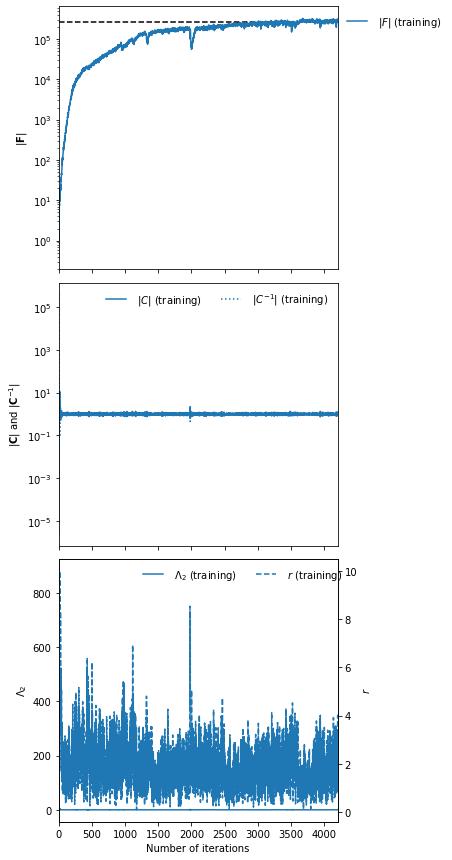

In [538]:
ax = IMNN.plot(expected_detF=detF_expected)
ax[0].set_yscale('log')

In [539]:
np.linalg.det(IMNN.F) / detF_expected

DeviceArray(1.0472138, dtype=float32)